## Flow-based features

While using one packet at a time to detect intrusions is very simple and straightforward, one can argue that relevant context is lost: The model does not consider the position of the packet in a flow. Therefor, most RTF-based machine learning models in literature consider the packet flows rather than individual packets. Recall that a network flow is identified by its 5-tuple: Source address, destination address, source port, destination port and protocol. The main idea is to sort flows based on their 5-tuple (flow ID), and then extract features from the resulting flows. In the literature, this is usually done as follows:

1. Iterate over the dataset in chronological order
    1. For each packet, extract the flow ID (if applicable)
    2. Store the entire packet (or a truncated version) in a data structure containing all packets with that flow ID
2. Decide on the dimensions of your input features
3. Iterate over each flow
    1. Extract the input features
    2. Store the extracted features

These extracted, stored features can then be used for training and or model evaluation. Deciding on the input feature dimensions not has become slightly more complicated however, when compared to using individual packets. Mainly, there are two decisions that need to be made:

1. How many packets do you include for one sample;
2. Do you only consider the beginning of the flow, or the entire flow.

As an example, the model we will use in this exercise was trained on samples of 4x64 bytes, created by taking the first 64 bytes of 4 subsequent packets in a flow. All packets in such a flow were considered.

### In hardware

The above approach does not work in hardware, as it requires having access to the entire dataset at once, and being able to store that entire dataset at once while processing its data. When performing network intrusion detection in hardware, there is only a limited amount of storage and it is impossible to predict what future packets will arrive. Therefor, another approach is necessary. One solution is to sort incoming packets into buckets according to their flow ID, and to empty those buckets whenever there needs to be made space for new incoming packets. Emptying a bucket then amounts to creating an input sample for the detection model. (Image: *n* individual buckets, packets are stored according to their flow ID FID).

<img src="./images/32_sorting.gif" width="600" height="150" />

### In softeware: exercise
In software, both approaches are possible: Either sorting the entire dataset beforehand, or filling and emptying buckets based on the incoming traffic. In this exercise, we will sort the entire dataset dataset for extracting features and conducting inference. 

In [4]:
import torch
import numpy as np
from lib.dataset import NIDSDataset

# We define this function to make the solution easier
def bytes_to_int(bytes_array):
    """
    Calculate the integer value that is represented by the provided array of bytes.
    Example: Input is [8, 0], which represents the hexadecimal 0x0800 number. This function will then calculate
    8 * 16^2 + 0 * 16^1 = 2048

    :param bytes_array: Array/list of bytes
    :type bytes_array: ``list`` of ``int``
    :return: The integer value represented by the array of bytes.
    :rtype: ``int``
    """
    n_bytes = len(bytes_array)

    value = 0

    for i in range(n_bytes):
        value += (pow(256, n_bytes - i - 1) * bytes_array[i])

    return value


# Initialize the dataset
dset = NIDSDataset(
    packets_file="./data/dataset_packets_v2.npy", 
    labels_file="./data/dataset_labels_v1.npy")

# The flow_dict contains a list of packets for each flow ID:
# flow_dict = {
#    "id_1": [..., ...],
#    "id_2": [..., ...],
#    ...
# }
flow_dict = {}

# Also include the label in the flow ID to account for the possibility that different packets from the same flow 
# could be malicious.
# Iterate over the dataset, sort all valid input features to dictionary

for packet in dset:
    label = packet.get_label()
    
    # Own code here
    header = np.zeros(64)
    
    protocol = 0
    src_addr = ""
    dst_addr = ""
    src_port = 0
    dst_port = 0
    
    flow_id = ""
    
    counter = 0
    for word in packet:
        
        if counter == 64:            
            if flow_id in flow_dict.keys():
                flow_dict[flow_id].append(header)
            else:
                flow_dict[flow_id] = [header]
            break
        elif counter == 36:
            dst_port = bytes_to_int(word[0:2])
            
            flow_id = "{}-{}-{}-{}-{}_{}".format(src_addr, dst_addr, src_port, dst_port, protocol, label)
        elif counter == 32:
            sb3 = bytes_to_int(word[0:1])
            sb4 = bytes_to_int(word[1:2])
            dst_addr += ".{}.{}".format(sb3, sb4)
            
            src_port = bytes_to_int(word[2:4])
        elif counter == 28:
            sb3 = bytes_to_int(word[0:1])
            sb4 = bytes_to_int(word[1:2])
            src_addr += ".{}.{}".format(sb3, sb4)
            
            db1 = bytes_to_int(word[2:3])
            db2 = bytes_to_int(word[3:4])
            dst_addr = "{}.{}".format(db1, db2)
            
        elif counter == 24:
            sb1 = bytes_to_int(word[2:3])
            sb2 = bytes_to_int(word[3:4])
            src_addr = "{}.{}".format(sb1, sb2)
        elif counter == 20:
                protocol = bytes_to_int(word[3:])
                
                # If the transport protocol is not TCP or UDP, skip
                if not ((protocol == 6) or (protocol == 17)):
                    break
                    
        elif counter == 12:
            ethertype = bytes_to_int(word[:2])
            
            # If the packet is not an IPv4 packet, we skip it
            if ethertype != 0x0800:
                break
        
        # Use word.shape[0] to account for word sizes smaller than for in the case of packets smaller than 64 bytes.
        header[counter:counter + word.shape[0]] = word
        
        if word.shape[0] < 4:
            # We reached the end of the packet: Store it
            if flow_id in flow_dict.keys():
                flow_dict[flow_id].append(header)
            else:
                flow_dict[flow_id] = [header]
            break
        
        counter += 4

print("We extracted {} flow IDs.".format(len(flow_dict.keys())))

We extracted 195 flow IDs.


Once the packets have been sorted, you can use the dictionary to extract your actual features.
Tip: Initialize your input samples using *np.zeros(...)*, so that input samples that only have one, two or three instead of four packets available can account for the missing data. Similarly, in hardware the missing bytes would have to be zero-padded.

In [5]:
input_buffer = []
label_buffer = []

for flow_id, packet_list in flow_dict.items():
    # Your code here
    label = flow_id.split("_")[-1]
    n_packets = len(packet_list)
    
    
    for i in range(0, n_packets, 4):
        input_sample = np.zeros(4 * 64)
        
        if n_packets - i < 4:
            input_sample[:(n_packets - i) * 64] = np.concatenate(packet_list[i:n_packets])
        else:
            input_sample[:] = np.concatenate(packet_list[i:i+4])
        
        input_buffer.append(input_sample)
        label_buffer.append(label)
    
print("We extracted {} input samples.".format(len(input_buffer)))
print("We extracted {} labels.".format(len(label_buffer)))

# The items in the input_buffer should be 320-sized numpy arrays
# These are then transform to tensors
input_tensors = []

for input_sample in input_buffer:
    # Turn the Numpy array into a PyTorch tensor
    input_tensor = torch.from_numpy(input_sample)
    # Change input dimensionality
    input_tensor = input_tensor.view(1, 1, 4 * 64)
    
    input_tensors.append(input_tensor)

We extracted 394 input samples.
We extracted 394 labels.


In [4]:
from lib.nn_model import ExampleCNN1D4x64

model = ExampleCNN1D4x64(13)

# Load the trained parameters
model.load_state_dict(torch.load("./data/cnn1d4x64.model"))

# Set the Batch Normalization layers for inference
model.eval()

ExampleCNN1D4x64(
  (layer1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.95, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer2): Sequential(
    (0): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.95, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer3): Sequential(
    (0): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.95, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (layer4): Sequential(
    (0): Conv1d(64, 96, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): Batch

In [5]:
from lib.nn_model import label_mapping

predictions = []

for input_tensor in input_tensors:
    output_tensor = model(input_tensor.float())
    
    _, predicted = torch.max(output_tensor, 1)
    predictions.append(predicted)

predictions = torch.stack(predictions, 0).numpy()

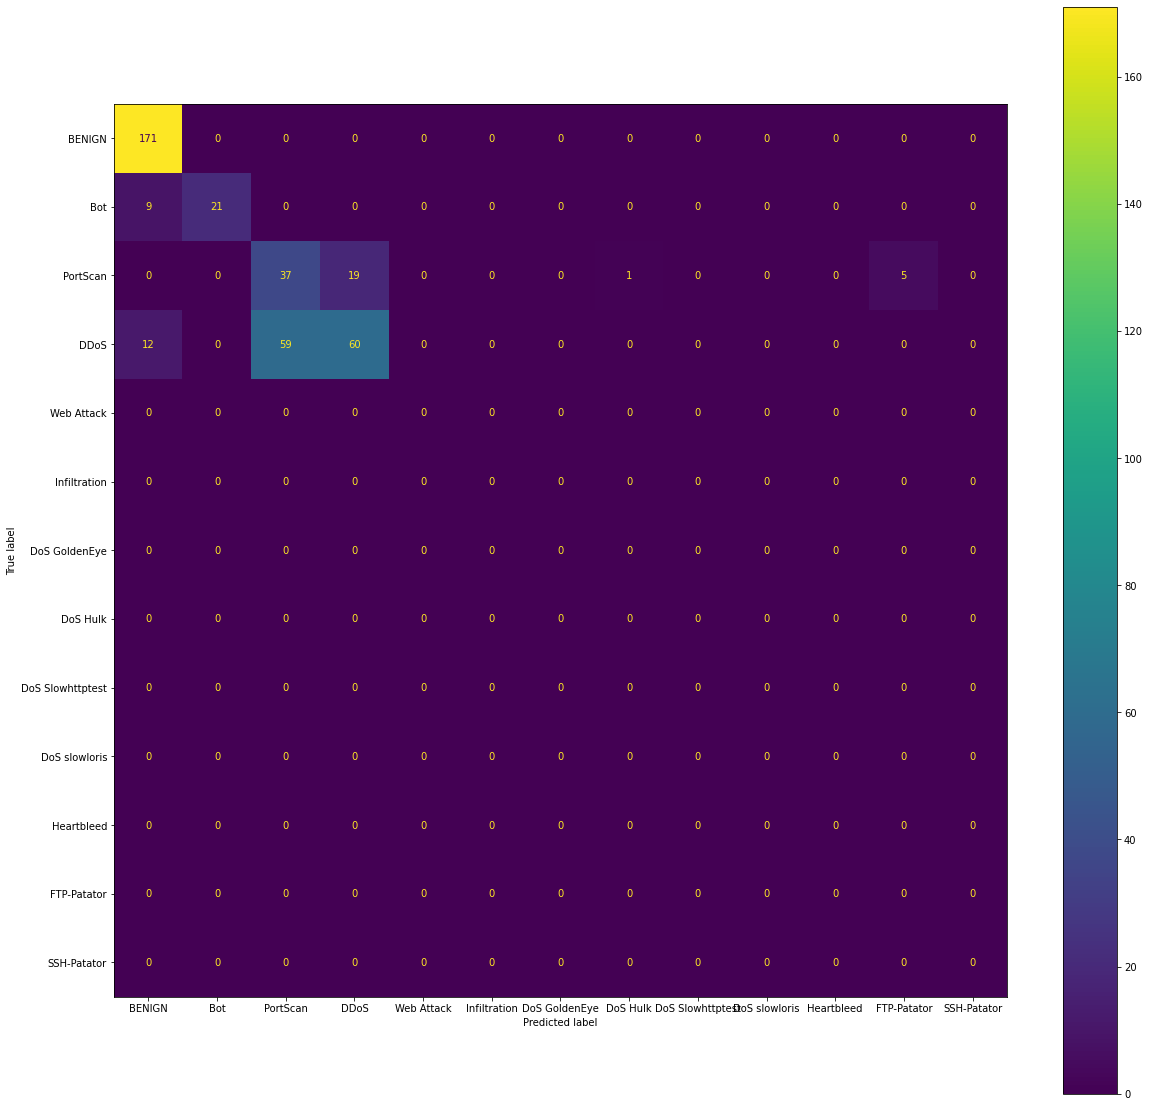

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Transform the indices to their corresponding class label:
labelled_predictions = []
for prediction in predictions:
    labelled_predictions.append(label_mapping[prediction[0]])

# Choose output figure size
_, ax = plt.subplots(figsize=(20, 20))

# Calculate the confusion matrix
cm = confusion_matrix(label_buffer, labelled_predictions, labels=label_mapping)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=label_mapping)
disp.plot(ax=ax)
plt.show()

In [7]:
from sklearn.metrics import classification_report

from sklearn.metrics import classification_report

print(classification_report(label_buffer, labelled_predictions, 
                            labels=label_mapping, 
                            target_names=label_mapping,
                            digits=4,
                            zero_division=0
                           ))

                  precision    recall  f1-score   support

          BENIGN     0.8906    1.0000    0.9421       171
             Bot     1.0000    0.7000    0.8235        30
        PortScan     0.3854    0.5968    0.4684        62
            DDoS     0.7595    0.4580    0.5714       131
      Web Attack     0.0000    0.0000    0.0000         0
    Infiltration     0.0000    0.0000    0.0000         0
   DoS GoldenEye     0.0000    0.0000    0.0000         0
        DoS Hulk     0.0000    0.0000    0.0000         0
DoS Slowhttptest     0.0000    0.0000    0.0000         0
   DoS slowloris     0.0000    0.0000    0.0000         0
      Heartbleed     0.0000    0.0000    0.0000         0
     FTP-Patator     0.0000    0.0000    0.0000         0
     SSH-Patator     0.0000    0.0000    0.0000         0

       micro avg     0.7335    0.7335    0.7335       394
       macro avg     0.2335    0.2119    0.2158       394
    weighted avg     0.7759    0.7335    0.7353       394

